In [5]:
import os
import matplotlib.pyplot as plt

In [31]:
path = "./new_masks/llama-7b"
head_groups = sorted([mask for mask in os.listdir(path)])

In [34]:
data = {}
for head_group in head_groups:
    data[head_group] = {}
    for desiderata in ["box_label_value", "object_value", "positional"]:
        with open(f"./new_masks/llama-7b-old/{head_group}/{desiderata}/0.01.txt", "r") as f:
            file_content = f.read()
            data[head_group][desiderata] = float(file_content.split("\n")[1].split(": ")[1])

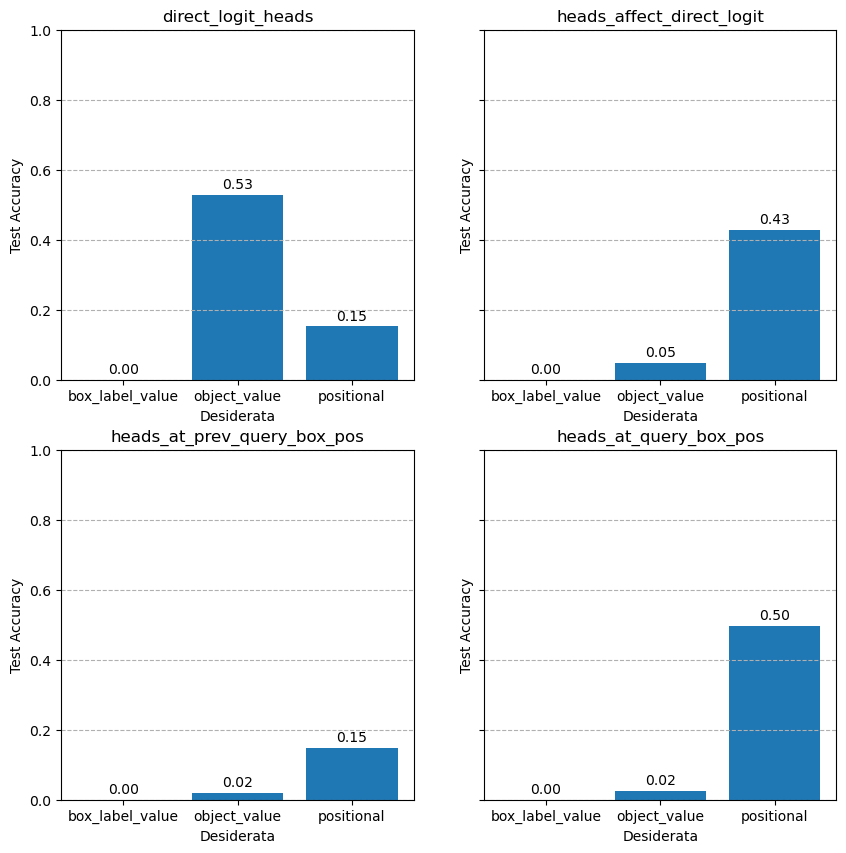

In [30]:
# Plot 4 subplots for each head group
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()
for i, head_group in enumerate(head_groups):
    axs[i].bar(data[head_group].keys(), data[head_group].values())
    axs[i].set_title(head_group)
    axs[i].set_ylim([0, 1])
    axs[i].set_ylabel("Test Accuracy")
    axs[i].set_xlabel("Desiderata")
    axs[i].grid(True, axis="y", linestyle="--")

# Annotation the accuracy values
for i, head_group in enumerate(head_groups):
    for desiderata in data[head_group].keys():
        axs[i].annotate(
            f"{data[head_group][desiderata]:.2f}",
            xy=(desiderata, data[head_group][desiderata] + 0.01),
            ha="center",
            va="bottom",
        )

plt.show()

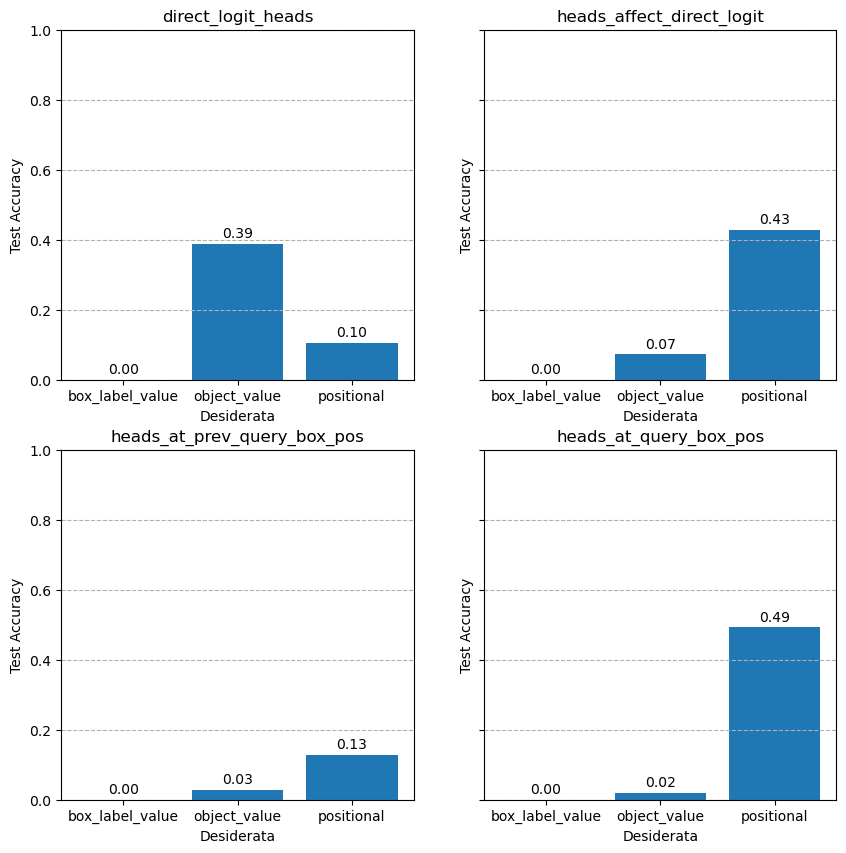

In [35]:
# Plot 4 subplots for each head group
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()
for i, head_group in enumerate(head_groups):
    axs[i].bar(data[head_group].keys(), data[head_group].values())
    axs[i].set_title(head_group)
    axs[i].set_ylim([0, 1])
    axs[i].set_ylabel("Test Accuracy")
    axs[i].set_xlabel("Desiderata")
    axs[i].grid(True, axis="y", linestyle="--")

# Annotation the accuracy values
for i, head_group in enumerate(head_groups):
    for desiderata in data[head_group].keys():
        axs[i].annotate(
            f"{data[head_group][desiderata]:.2f}",
            xy=(desiderata, data[head_group][desiderata] + 0.01),
            ha="center",
            va="bottom",
        )

plt.show()